In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import os
import tensorflow_addons as tfa
import time
import math
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


2023-08-22 18:01:20.663343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 18:01:21.330914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/khubayeeb_k/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
class_types = ["Cr", "Sc", "In", "PS", "RS", "Pa"]


In [ ]:
import glob
os.chdir("neu-metal-surface/train/")
"""
Cr - 0
Sc - 1
In - 2
PS - 3
RS - 4
Pa - 5
"""
ls_Cr = glob.glob("Cr*.bmp")
ls_Sc = glob.glob("Sc*.bmp")
ls_In = glob.glob("In*.bmp")
ls_PS = glob.glob("PS*.bmp")
ls_RS = glob.glob("RS*.bmp")
ls_Pa = glob.glob("Pa*.bmp")

BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)
image_size = 224
patch_size = 16
UNLABLED_DATA_SIZE = 18974
LABLED_DATA_SIZE_TRAIN = 1283
LABLED_DATA_SIZE_TEST = 517

STEPS_PER_EPOCH = (UNLABLED_DATA_SIZE + LABLED_DATA_SIZE_TRAIN) // BATCH_SIZE
UNLABELED_BATCH_SIZE = UNLABLED_DATA_SIZE // STEPS_PER_EPOCH
LABLED_BATCH_SIZE_TRAIN = LABLED_DATA_SIZE_TRAIN // STEPS_PER_EPOCH
LABLED_BATCH_SIZE_TEST = LABLED_DATA_SIZE_TEST//(STEPS_PER_EPOCH//10)

print(STEPS_PER_EPOCH, UNLABELED_BATCH_SIZE,
      LABLED_BATCH_SIZE_TRAIN, LABLED_BATCH_SIZE_TEST)

AUTOTUNE = tf.data.AUTOTUNE


def decode_jpg(img_name):
    img = tf.io.read_file(img_name)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def preprocessing_jpg(img_name, unlabled_img_labels):
    return decode_jpg(img_name), unlabled_img_labels


1266 14 1 4


In [ ]:
train_image_path, train_image_labels = ls_Cr + ls_Sc + ls_In + ls_PS + ls_RS + \
    ls_Pa, [0]*len(ls_Cr) + [1]*len(ls_Sc) + [2]*len(ls_In) + \
    [3]*len(ls_PS) + [4]*len(ls_RS) + [5]*len(ls_Pa)


In [ ]:
train_image_path = [os.path.join(
    "neu-metal-surface", "train", path) for path in train_image_path]
len(train_image_labels) == len(train_image_path)


True

In [ ]:
def decode_bmp(img_name):
    img = tf.io.read_file(img_name)
    img = tf.image.decode_bmp(img, channels=0)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def preprocessing_bmp(img_name, labels):
    return decode_bmp(img_name), labels


In [ ]:
labeled_train_data = tf.data.Dataset.from_tensor_slices(
    (train_image_path, train_image_labels))
labeled_train_data = labeled_train_data.map(preprocessing_bmp).prefetch(12)
labeled_train_data = labeled_train_data.shuffle(LABLED_DATA_SIZE_TRAIN)
labeled_train_data = labeled_train_data.batch(
    LABLED_BATCH_SIZE_TRAIN).prefetch(AUTOTUNE)


2023-08-22 18:01:22.139293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-22 18:01:22.159201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-22 18:01:22.159441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
os.chdir("../test")


In [ ]:
ls_Cr = glob.glob("Cr*.bmp")
ls_Sc = glob.glob("Sc*.bmp")
ls_In = glob.glob("In*.bmp")
ls_PS = glob.glob("PS*.bmp")
ls_RS = glob.glob("RS*.bmp")
ls_Pa = glob.glob("Pa*.bmp")


In [ ]:
test_image_path, test_image_labels = ls_Cr + ls_Sc + ls_In + ls_PS + ls_RS + \
    ls_Pa, [0]*len(ls_Cr) + [1]*len(ls_Sc) + [2]*len(ls_In) + \
    [3]*len(ls_PS) + [4]*len(ls_RS) + [5]*len(ls_Pa)
test_image_path = [os.path.join("neu-metal-surface", "test", path)
                   for path in test_image_path]


In [ ]:
labeled_test_data = tf.data.Dataset.from_tensor_slices(
    (test_image_path, test_image_labels))
labeled_test_data = labeled_test_data.map(preprocessing_bmp)
labeled_test_data = labeled_test_data.shuffle(LABLED_DATA_SIZE_TEST)
labeled_test_data = labeled_test_data.batch(
    LABLED_BATCH_SIZE_TEST).prefetch(AUTOTUNE)


In [ ]:
os.chdir(os.path.join("..", ".."))


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from skimage import io
X_train = []
X_test = []
for path in train_image_path:
    # img = tf.convert_to_tensor(io.imread(path), dtype=tf.float32)
    img = resize(io.imread(path), output_shape=[*IMAGE_SIZE])
    img = np.reshape(img, newshape=(*img.shape, 1))
    X_train.append(img)
for path in test_image_path:
    # img = tf.convert_to_tensor(io.imread(path), dtype=tf.float32)
    img = resize(io.imread(path), output_shape=[*IMAGE_SIZE])
    img = np.reshape(img, newshape=(*img.shape, 1))
    X_test.append(img)
X_train, X_test = np.array(X_train), np.array(X_test)

# y_train, y_test = np.array(train_image_labels), np.array(test_image_labels)

# enc = OneHotEncoder(handle_unknown='ignore')
# y_train = enc.fit_transform(np.expand_dims(
#     np.array(train_image_labels), axis=-1))
# y_test = enc.transform(np.expand_dims(np.array(test_image_labels), axis=-1))


y_train = np.expand_dims(
    np.array(train_image_labels), axis=-1)
y_test = np.expand_dims(np.array(test_image_labels), axis=-1)


print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(1728, 224, 224, 1) (72, 224, 224, 1)
(1728, 1) (72, 1)


In [ ]:
# define the number of classes
NUM_CLASSES = 6
# Use Kaggle_02 - Mem_MAX

# input_shape = (224, 224, 3)


In [ ]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 8

# AUGMENTATION
IMAGE_SIZE = 224
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 6
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [1024, 512]


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)


In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)


In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(
            attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)


In [ ]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS,
                   dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [ ]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError(
                "Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * \
                tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(X_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(
                5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
    )
    _, accuracy, top_5_accuracy = model.evaluate(
        X_test, y_test, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history, model


# Run experiments with the vanilla ViT
vit = create_vit_classifier(vanilla=True)
history = run_experiment(vit)

# Run experiments with the Shifted Patch Tokenization and
# Locality Self Attention modified ViT
vit_sl = create_vit_classifier(vanilla=False)
history, vit_sl = run_experiment(vit_sl)


Epoch 1/50
  4/195 [..............................] - ETA: 4s - loss: 3.1557 - accuracy: 0.2188 - top-5-accuracy: 0.9375   

2023-08-22 18:01:31.776895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


195/195 [==============================] - 11s 31ms/step - loss: 2.7908 - accuracy: 0.3537 - top-5-accuracy: 0.9280 - val_loss: 2.2525 - val_accuracy: 0.2428 - val_top-5-accuracy: 0.9711
Epoch 2/50
195/195 [==============================] - 5s 27ms/step - loss: 1.8819 - accuracy: 0.4238 - top-5-accuracy: 0.9537 - val_loss: 2.0584 - val_accuracy: 0.3699 - val_top-5-accuracy: 0.9827
Epoch 3/50
195/195 [==============================] - 5s 27ms/step - loss: 1.4188 - accuracy: 0.5170 - top-5-accuracy: 0.9711 - val_loss: 1.3684 - val_accuracy: 0.5491 - val_top-5-accuracy: 0.9827
Epoch 4/50
195/195 [==============================] - 5s 27ms/step - loss: 1.0798 - accuracy: 0.6302 - top-5-accuracy: 0.9904 - val_loss: 0.8740 - val_accuracy: 0.6590 - val_top-5-accuracy: 0.9942
Epoch 5/50
195/195 [==============================] - 5s 27ms/step - loss: 0.8935 - accuracy: 0.6875 - top-5-accuracy: 0.9949 - val_loss: 0.5162 - val_accuracy: 0.7919 - val_top-5-accuracy: 1.0000
Epoch 6/50
195/195 [=====

3/3 [==============================] - 0s 16ms/step
Classification Report:

              precision    recall  f1-score   support

          Cr       0.86      1.00      0.92        12
          Sc       1.00      0.83      0.91        12
          In       0.92      1.00      0.96        12
          PS       1.00      0.92      0.96        12
          RS       1.00      1.00      1.00        12
          Pa       0.83      0.83      0.83        12

    accuracy                           0.93        72
   macro avg       0.94      0.93      0.93        72
weighted avg       0.94      0.93      0.93        72



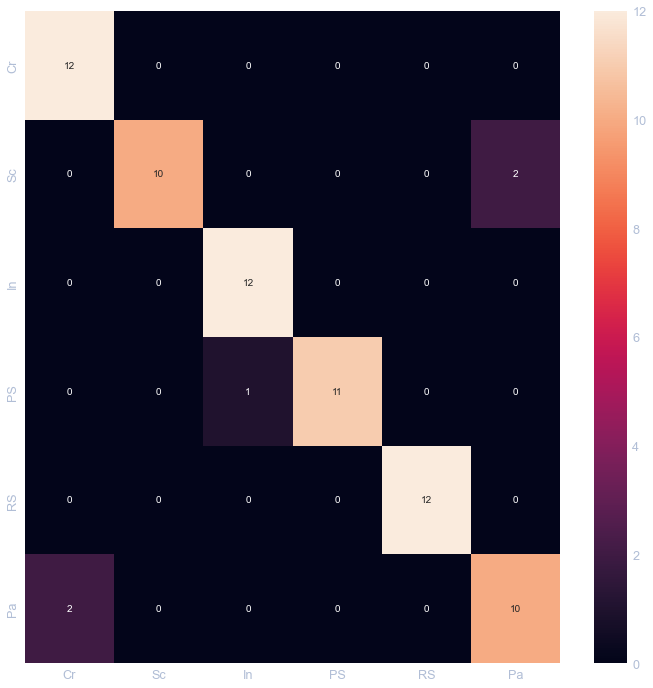

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


def conf_matrix(model, X_test, Y_test):

    predictions = model.predict(X_test)
    Y_pred = np.argmax(np.round(predictions), axis=1)

    cm = confusion_matrix(Y_test, Y_pred)

    print("Classification Report:\n")

    cr = classification_report(Y_test,
                               Y_pred,
                               target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)   # change to save to file?

    plt.figure(figsize=(12, 12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels=[class_types[i] for i in range(len(class_types))],
                          yticklabels=[class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()
    plt.show()


conf_matrix(vit_sl, X_test, y_test)
